In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim

import time
import tqdm

import tkinter
import pickle

from IPython.display import clear_output

import sys
sys.path.append('..')

import pyro
from pyro.infer import HMC, MCMC, NUTS
from samplers_new import mala, i_sir, ex2_mcmc
import ot
import jax
import gc

from cifar10_experiments.models import Generator, Discriminator

from sampling_utils.adaptive_mc import CISIR, Ex2MCMC, FlowMCMC
from sampling_utils.adaptive_sir_loss import MixKLLoss
from sampling_utils.distributions import (
    Banana,
    CauchyMixture,
    Distribution,
    Funnel,
    HalfBanana,
    IndependentNormal,
)
from sampling_utils.ebm_sampling import MALA
from sampling_utils.flows import RNVP
from sampling_utils.metrics import ESS, acl_spectrum
from sampling_utils.total_variation import (
    average_total_variation,
)

2023-05-29 16:05:38.002025: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#!pip install pyro-ppl easydict pot flax mlpaper
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def sample_nuts(target, proposal, device = 'cpu', num_samples=1000, burn_in=1000, batch_size=1, rand_seed = 42):
    def true_target_energy(z):
        return -target(z)

    def energy(z):
        z = z["points"]
        return true_target_energy(z).sum()
    start_time = time.time()
    # kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
    kernel_true = NUTS(potential_fn=energy, full_mass=False)
    #kernel_true = HMC(potential_fn=energy, full_mass=False)
    pyro.set_rng_seed(rand_seed)
    init_samples = proposal.sample((batch_size,)).to(device)
    print(init_samples.shape) 
    #init_samples = torch.zeros_like(init_samples)
    dim = init_samples.shape[-1]
    init_params = {"points": init_samples}
    mcmc_true = MCMC(
        kernel=kernel_true,
        num_samples=num_samples,
        initial_params=init_params,
        warmup_steps=burn_in,
    )
    mcmc_true.run()
    q_true = mcmc_true.get_samples(group_by_chain=True)["points"].cpu()
    samples_true = np.array(q_true.view(-1, batch_size, dim))
    end_time = time.time()
    return end_time-start_time, samples_true

In [5]:
def plot_learned_density(
    flow,
    proposal,
    fig=None,
    device="cpu",
    xlim=[-1, 1],
    ylim=[-1, 1],
    rest=0.0,
):
    if fig is None:
        fig = plt.figure()
    n_pts = 200
    z = proposal.sample((n_pts**2,))
    x = np.linspace(*xlim, n_pts)
    y = np.linspace(*ylim, n_pts)
    xx, yy = np.meshgrid(x, y)
    zz = np.stack([xx, yy], -1)
    z[:, :2] = torch.FloatTensor(zz).view(-1, 2).to(device)
    z[:, 2:] = torch.FloatTensor([rest] * n_pts**2)[:, None]

    inv, minus_log_jac = flow.inverse(z)
    minus_log_jac = minus_log_jac.reshape(n_pts, n_pts)
    inv = inv.reshape(n_pts, n_pts, -1)
    vals = (proposal(inv) + minus_log_jac).exp().detach()

    im = plt.contourf(xx, yy, vals.reshape(n_pts, n_pts), cmap="GnBu")
    fig.colorbar(im)
    return fig

def compute_metrics(
    xs_true,
    xs_pred,
    name=None,
    n_samples=1000,
    scale=1.0,
    trunc_chain_len=None,
    ess_rar=1,
):
    metrics = dict()
    key = jax.random.PRNGKey(0)
    n_steps = 25
    # n_samples = 100

    ess = ESS(
        acl_spectrum(
            xs_pred[::ess_rar] - xs_pred[::ess_rar].mean(0)[None, ...],
        ),
    ).mean()
    metrics["ess"] = ess

    xs_pred = xs_pred[-trunc_chain_len:]
    print(xs_true.shape)
    print(xs_pred.shape)

    tracker = average_total_variation(
        key,
        xs_true,
        xs_pred,
        n_steps=n_steps,
        n_samples=n_samples,
    )

    metrics["tv_mean"] = tracker.mean()
    metrics["tv_conf_sigma"] = tracker.std_of_mean()

    mean = tracker.mean()
    std = tracker.std()

    metrics["emd"] = 0
    #Cost_matr_isir = ot.dist(x1 = isir_res[j][i], x2=gt_samples[i], metric='sqeuclidean', p=2, w=None)
    for b in range(xs_pred.shape[1]):
        M = ot.dist(xs_true / scale, xs_pred[:, b,:] / scale)
        emd = ot.lp.emd2([], [], M, numItermax = 1e6)
        metrics["emd"] += emd / xs_pred.shape[1]

    if name is not None:
        print(f"===={name}====")
    print(
        f"TV distance. Mean: {mean:.3f}, Std: {std:.3f}. \nESS: {ess:.3f} \nEMD: {emd:.3f}",
    )

    return metrics

In [6]:
def plot_metrics(metrics, ndims, savepath=None, scale=1.0, colors=None):
    axs_names = ["Sliced TV", "ESS", "EMD ratio"]  # (on scaled data)']
    ncols = len(axs_names)

    figs = []
    axs = []
    for _ in range(ncols):
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        figs.append(fig)
        axs.append(ax)

    mala_emd = metrics['MALA']['emd']
    
    for (name, res), color in zip(metrics.items(), colors):
        for k, v in res.items():
            res[k] = np.array(v)

        arr = res["tv_mean"]
        axs[0].plot(ndims, arr, label=name, marker="o", color=color)

        axs[0].fill_between(
            ndims,
            res["tv_mean"] - 1.96 * res["tv_conf_sigma"],
            res["tv_mean"] + 1.96 * res["tv_conf_sigma"],
            alpha=0.2,
        )

        arr = res["ess"]
        axs[1].plot(ndims, arr, label=name, marker="o", color=color)

        if name != 'MALA':
            arr = mala_emd / res["emd"]
            axs[2].plot(ndims, arr, label=name, marker="o", color=color)
        #axs[2].set_yscale("log")

    for ax, fig, name in zip(axs, figs, axs_names):
        ax.grid()
        ax.set_title(name.split(' ')[0])
        ax.set_xlabel("dim")
        if name == "EMD ratio":
            ax.legend()

        fig.tight_layout()

        if savepath is not None:
            fig.savefig(Path(savepath, f"{name}.pdf"))

In [7]:
n_steps = 1
dist = "Funnel"
dim = 30
scale_proposal = 1.
device='cpu'
scale_isir = 3.
dist_class = "Funnel"
a = 2.0
b = 0.5
target = Funnel(
                dim=dim,
                device=device,
                a = a,
                b = b
                #**dist_params.dict,
)

In [8]:
#device = "cuda"
#method_metric_dict = defaultdict(lambda: defaultdict(list))

In [9]:
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = scale_proposal * torch.ones(dim).to(device)
scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_proposal,
    device=device,
)

proposal_ex2 = IndependentNormal(
    dim=dim,
    loc=loc_proposal,
    scale=scale_isir,
    device=device,
)

### Generate ground-truth samples

In [10]:
N_samples = 1*10**3
np.random.seed(43)
True_samples = np.random.randn(N_samples,dim)
True_samples[:,0] *= a 
for k in range(1,dim):
    True_samples[:,k] *= np.exp(True_samples[:,0]/2) 

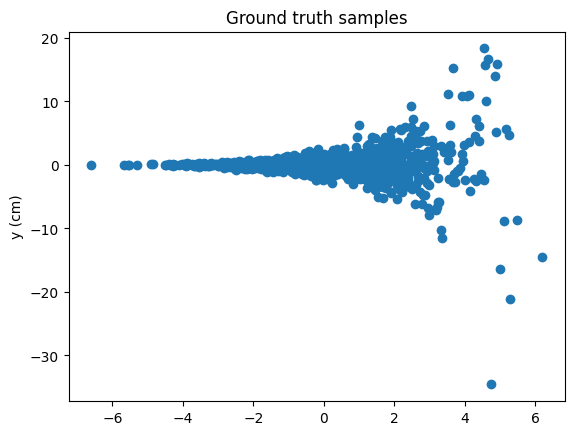

In [11]:
fig,ax=plt.subplots(1,1)
#cp = ax.contourf(X, Y, dens_vals)
#fig.colorbar(cp) # Add a colorbar to a plot
ax.scatter(True_samples[:,0],True_samples[:,1])
ax.set_title('Ground truth samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with NUTS

In [12]:
#samples to compute ground-truth metrics
Nuts_samples_ground_truth = 2000
#Nuts_samples_comparison
trunc_chain_len = 1000
#nuts samples burn_in
nuts_burn_in = 500
#nuts batch size
nuts_batch = 1

### Generate ground-truth samples (with NUTS)

In [13]:
#samples_true = sample_nuts(
#                target,
#                proposal,
#                num_samples=Nuts_samples_ground_truth,#config.trunc_chain_len,
#                batch_size=nuts_batch, #config.batch_size
#)[:, 0, :]
#print(samples_true.shape)

In [14]:
rand_seed = 45
time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=1000,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
)
print(sample_nuts_ref.shape)

torch.Size([1, 30])


Sample: 100%|█| 1500/1500 [00:20, 71.48it/s, step size=1.80e-01, acc. prob=0.879

(1000, 1, 30)


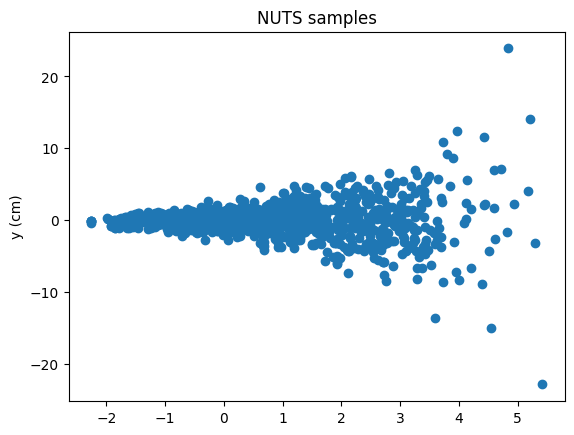

In [15]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1])
ax.set_title('NUTS samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [16]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.106, Std: 0.024. 
ESS: 0.372 
EMD: 264.833


### Sample with Ex2MCMC

In [17]:
params = {
      "N": 2000,
      "grad_step": 0.1,
      "adapt_stepsize": True, #True
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0, #0.75
      "mala_steps": 3
}
        
n_steps_ex2 = 5000
batch_size = 1

In [18]:
distr = torch.distributions.Normal(torch.zeros(1).to(device), torch.ones(1).to(device))
logprob1 = distr.log_prob(torch.ones(1).to(device))
print(logprob1)

tensor([-1.4189])


In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
mcmc = Ex2MCMC(**params, dim=dim)
pyro.set_rng_seed(43)
start = proposal_ex2.sample((batch_size,)).to(device)
print(start)
# s = time.time()
out = mcmc(start, target, proposal_ex2, n_steps = n_steps_ex2)
print(out[1])
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_ex2_final = sample[:,0,:]
print(sample_ex2_final.shape)

tensor([[-0.0498, -1.4004,  6.2727,  1.8447, -1.6863, -1.2428, -3.9003, -0.3036,
         -3.2998, -1.4060, -2.5201,  2.0605, -0.2033, -0.2658,  2.6353,  1.2985,
         -2.1344,  3.1276, -2.2854, -1.4491, -2.3312, -1.3452, -2.9695,  2.3428,
          3.9753, -3.4880, -6.3559,  1.6409, -3.5003, -3.0598]])


100%|██████████████████████████████████████| 5000/5000 [00:18<00:00, 265.99it/s]

tensor([0.4999])
(5000, 30)


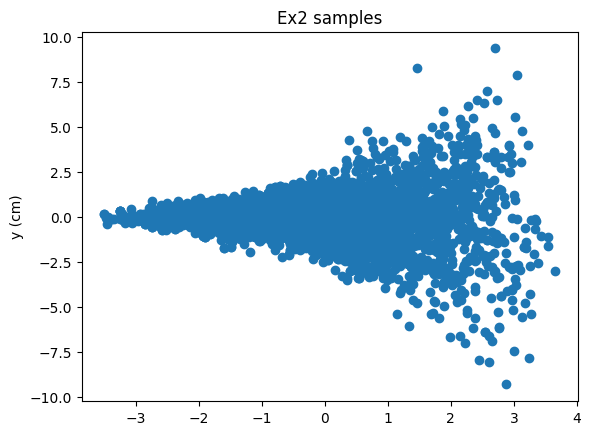

In [21]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1])
ax.set_title('Ex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

### Sample with Flex2MCMC (adaptive version)

In [22]:
params_flex = {
      "N": 200,
      "grad_step": 0.2,
      "adapt_stepsize": True,
      "corr_coef": 0.0,
      "bernoulli_prob_corr": 0.0,
      "mala_steps": 0,
    "flow": {
      "num_flows": 4, # number of normalizing layers 
      "lr": 1e-3, # learning rate 
      "batch_size": 100,
      "n_steps": 1000,
    }
}
batch_size = 1
torch.cuda.empty_cache()

In [23]:
pyro.set_rng_seed(42)
mcmc = Ex2MCMC(**params_flex, dim=dim)
verbose = mcmc.verbose
mcmc.verbose = False
flow = RNVP(params_flex["flow"]["num_flows"], dim=dim, device = device)
flow_mcmc = FlowMCMC(
    target,
    proposal,
    device,
    flow,
    mcmc,
    batch_size=params_flex["flow"]["batch_size"],
    lr=params_flex["flow"]["lr"],
)
flow.train()
out_samples, nll = flow_mcmc.train(
    n_steps=params_flex["flow"]["n_steps"],
)
assert not torch.isnan(
    next(flow.parameters())[0, 0],
).item()
gc.collect()
torch.cuda.empty_cache()
flow.eval()
mcmc.flow = flow
mcmc.verbose = verbose

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 34.32it/s]


In [24]:
#sample from a normalizing flow
n_steps_flex2 = 1000
batch_size = 1
pyro.set_rng_seed(42)
start = proposal.sample((batch_size,))
mcmc.N = 200
mcmc.mala_steps = 0
mcmc.grad_step = 0.1
# s = time.time()
out = mcmc(start, target, proposal, n_steps = n_steps_flex2)
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out
sample = np.array(
    [_.detach().numpy() for _ in sample],
).reshape(-1, batch_size, dim)
sample_flex2_new = sample
#resample with 0 mala steps
torch.cuda.empty_cache()
mcmc.mala_steps = 3
out_new = mcmc(start, target, proposal, n_steps = n_steps_flex2)
print(out_new[1])
out_new = out_new[0]
out_new = np.array(
    [_.detach().numpy() for _ in out_new],
).reshape(-1, batch_size, dim)
sample_flex2_final = out_new
print(sample_flex2_final.shape)

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 165.71it/s]

tensor([0.5000])
(1000, 1, 30)


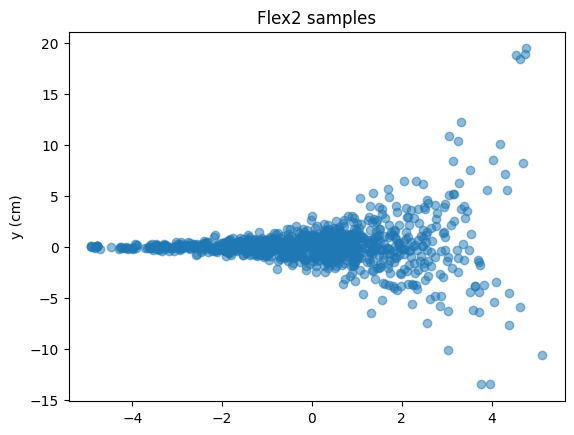

In [25]:
fig,ax=plt.subplots(1,1)
ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],alpha = 0.5)
ax.set_title('Flex2 samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
#ax.set_yscale('log')
plt.show()

In [26]:
metrics = compute_metrics(
                    True_samples,
                    sample_flex2_final,
                    name="Flex2",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====Flex2====
TV distance. Mean: 0.057, Std: 0.017. 
ESS: 0.438 
EMD: 203.026


In [27]:
dim = 200
loc_proposal = torch.zeros(dim).to(device)
scale_proposal = 1.0 * torch.ones(dim).to(device)
#scale_isir = scale_isir * torch.ones(dim).to(device)

proposal = IndependentNormal(
        dim=dim,
        loc=loc_proposal,
        scale=scale_proposal,
        device=device,
)

n_samples = 2000
pyro.set_rng_seed(42)
sample_2 = proposal.sample((n_samples,))
sample_2 = sample_2.unsqueeze(1).cpu().numpy()
print(sample_2.shape)
sample_1 = proposal.sample((n_samples,)).cpu().numpy()
metrics = compute_metrics(
                    sample_1,
                    sample_2,
                    name="Gaussian noise",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(2000, 1, 200)
(2000, 200)
(1000, 1, 200)


  0%|          | 0/25 [00:00<?, ?it/s]

====Gaussian noise====
TV distance. Mean: 0.035, Std: 0.009. 
ESS: 0.832 
EMD: 311.477


In [28]:
print(np.sum(True_samples[:,0] < -2))
print(np.sum(sample_nuts_ref[:,0,0] < -2))
print(np.sum(sample_flex2_final[:,0,0] < -2))

153
5
162


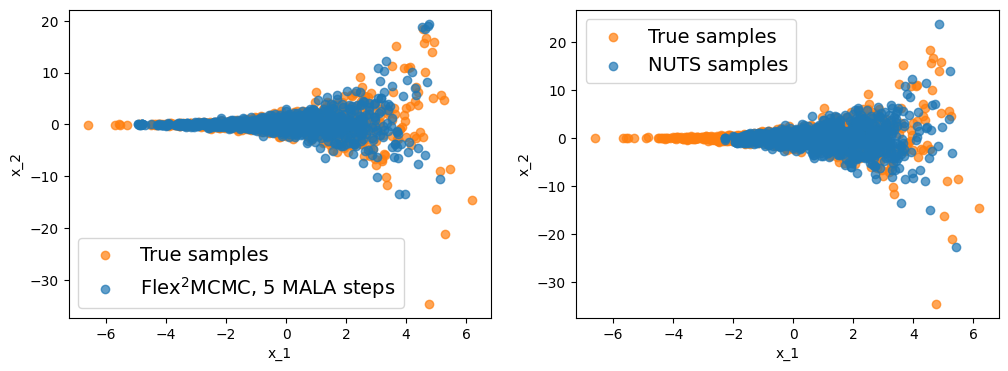

In [29]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[0].scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4', alpha = 0.7, label = "Flex$^2$MCMC, 5 MALA steps")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel('x_1')
ax[0].set_ylabel('x_2')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,0],True_samples[:,1],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[1].scatter(sample_nuts_ref[:,0,0],sample_nuts_ref[:,0,1],c='#1f77b4', alpha = 0.7, label = "NUTS samples")
#ax[1].set_title('All samples')
ax[1].set_xlabel('x_1')
ax[1].set_ylabel('x_2')
#ax.set_yscale('log')
plt.legend(fontsize=14)
#plt.savefig(Path(
#        "./",
#        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
#        ), format="pdf", bbox_inches="tight") 
plt.savefig("funnel_visualize_d_100.png",format="png", bbox_inches="tight")
plt.show()

In [30]:
import tensors.sirt2 as sirt

In [33]:
n_steps = 1
dist = "Funnel"
d = 30
a = 2.0
b = 0.5
num_centers = 50
sigma = 0.2
target = sirt.Funnel1(a, b) # normal_density_general(np.zeros(d), Sigma) #
dots = [(-17., 17.)] * d
dots[0] = (-6., 6.)
steps = [100] *d

In [34]:
cross, grids = sirt.TT_cross_density(target, dots, steps, d, sirt.make_meshgrids_lin)
lists = cross.to_list(cross)
ans, pdfs = sirt.SIRT_sampling(cross.to_list(cross), np.random.uniform(size=(2000, d)),
                            grids)

None


/home/hdilab/miniconda3/lib/python3.10/site-packages/tt/multifuncrs2.py:179: RuntimeWarning: invalid value encountered in double_scalars
  dy = np.linalg.norm(newy - oldy) / np.linalg.norm(newy)


=multifuncrs= sweep 1{2}, max_dy: inf, erank: 5.83095
=multifuncrs= sweep 2{1}, max_dy: 4.600e+00, erank: 8.78825
=multifuncrs= sweep 2{2}, max_dy: 4.600e+00, erank: 11.128
=multifuncrs= sweep 3{1}, max_dy: 1.955e+02, erank: 9.52365
=multifuncrs= sweep 3{2}, max_dy: 1.955e+02, erank: 11.1056
=multifuncrs= sweep 4{1}, max_dy: 1.588e+00, erank: 14.4291
=multifuncrs= sweep 4{2}, max_dy: 1.588e+00, erank: 15.6918
=multifuncrs= sweep 5{1}, max_dy: 2.840e-02, erank: 15.7956
=multifuncrs= sweep 5{2}, max_dy: 5.799e-02, erank: 16.778
=multifuncrs= sweep 6{1}, max_dy: 2.739e-02, erank: 17.7276
=multifuncrs= sweep 6{2}, max_dy: 1.441e-01, erank: 20.4426
=multifuncrs= sweep 7{1}, max_dy: 5.120e-02, erank: 21.8495
=multifuncrs= sweep 7{2}, max_dy: 2.146e-01, erank: 24.6279
=multifuncrs= sweep 8{1}, max_dy: 5.798e-02, erank: 26.1623
=multifuncrs= sweep 8{2}, max_dy: 1.531e-01, erank: 29.9327
=multifuncrs= sweep 9{1}, max_dy: 4.753e-02, erank: 32.5249
=multifuncrs= sweep 9{2}, max_dy: 3.243e-01, era

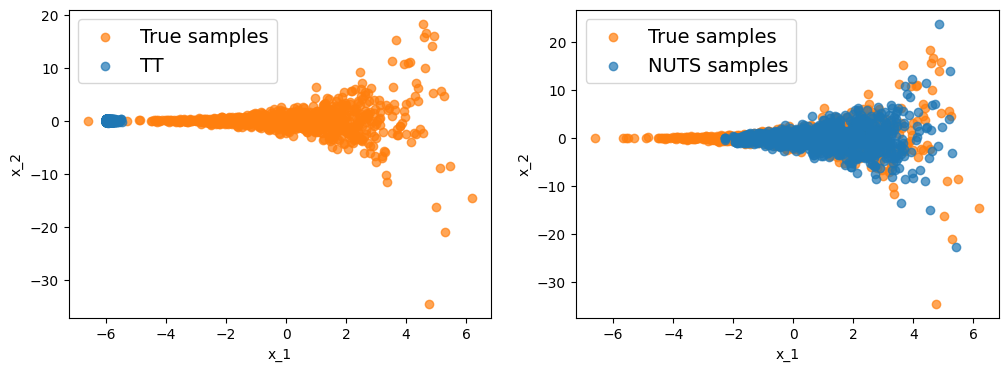

In [33]:
i, j = 0, 1
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(True_samples[:,i],True_samples[:,j],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[0].scatter(ans[:,i],ans[:,j],c='#1f77b4', alpha = 0.7, label = "TT")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
#ax[0].set_title('All samples')
ax[0].set_xlabel(f'x_{i + 1}')
ax[0].set_ylabel(f'x_{j + 1}')
ax[0].legend(fontsize=14)
#ax.set_yscale('log')
#plt.legend()
#plt.show()
#ax.scatter(sample_flex2_final[:,0,0],sample_flex2_final[:,0,1],c='#1f77b4',label = "Flex samples")
#ax.scatter(sample_ex2_final[:,0],sample_ex2_final[:,1],c='#ff7f0e',label = "Ex2 samples")
ax[1].scatter(True_samples[:,i],True_samples[:,j],c='#ff7f0e', alpha = 0.7, label = "True samples")
ax[1].scatter(sample_nuts_ref[:,0,i],sample_nuts_ref[:,0,j],c='#1f77b4', alpha = 0.7, label = "NUTS samples")
#ax[1].set_title('All samples')
ax[1].set_xlabel(f'x_{i+1}')
ax[1].set_ylabel(f'x_{j+1}')
#ax.set_yscale('log')
plt.legend(fontsize=14)
#plt.savefig(Path(
#        "./",
#        f"flow_funnel_samples_dim_{dim}_var_2_N_{mcmc.N}_mala_{mcmc.mala_steps}.pdf",
#        ), format="pdf", bbox_inches="tight") 
plt.savefig("funnel_visualize_d_100.png",format="png", bbox_inches="tight")
plt.show()

In [34]:
sample_nuts_ref.shape

(1000, 1, 30)

In [35]:
def log_grad_funnel(a, b):
    def dens(z):
        ans = np.empty_like(z)
        d = z.shape[-1]
        z0 = z[..., 0]
        z1 = z[..., 1:]
        ans[..., 0] = -z0/a**2 + b * np.exp(-2 * b * z0) * (z1**2).sum(-1) - (d-1) * b
        ans[..., 1:] = -np.exp(-2*b*z0).reshape(-1, 1) * z1
        return ans
    
    return dens


def funnel(a, b):
    def density(x):
        x = x.reshape(1, -1)
        d = x.shape[1]
        part1 = x[:, 0]**2/(2 * a**2)
        part2 = (x[:, 1:]**2).sum(axis=1)
        part2 *= np.exp(-2 * b * x[:, 0])/2
        part2 += (d-1) * b * x[:, 0]
        ans = part1 + part2#  + d/10 * np.log(2 * np.pi) + d/10 * np.log(a)
        ans = np.exp(-ans)
        return ans

    return density



In [36]:
from scipy.optimize import approx_fprime

a = 2.0
b = 0.5
d=6
z = np.random.randn(d)
ap_gr = approx_fprime(z, log_funnel(a, b))
gr = log_grad_funnel(a, b)(z.reshape(1, -1))

NameError: name 'log_funnel' is not defined

In [31]:
print(ap_gr)
print(gr)

NameError: name 'ap_gr' is not defined

In [29]:
metrics = compute_metrics(
                    True_samples,
                    sample_nuts_ref,
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.106, Std: 0.024. 
ESS: 0.372 
EMD: 264.833


In [30]:
metrics = compute_metrics(
                    True_samples,
                    ans.reshape(2000, 1, -1),
                    name="TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.170, Std: 0.024. 
ESS: 0.819 
EMD: 173.201


In [41]:
from tensors.MALA import mala
malas = [0] * 8
a = 2.0
b = 0.5
k = 7
x, accs = mala(ans, log_grad_funnel(a, b), funnel(a, b), 0.001, k=1)

In [42]:
accs

[0.0]

In [119]:
metrics = compute_metrics(
                    True_samples,
                    x.reshape(2000, 1, -1),
                    name="TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
)

(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.432, Std: 0.022. 
ESS: 0.799 
EMD: 189.352


In [46]:
ds = np.arange(5, 45, 5)
anses = []
a = 2.0
b = 0.5
for d in tqdm.notebook.tqdm(ds):
    target = sirt.Funnel1(a, b)
    dots = [(-17., 17.)] * d
    dots[0] = (-6., 6.)
    steps = [100] *d
    cross, grids = sirt.TT_cross_density(target, dots, steps, d, sirt.make_meshgrids_lin)
    lists = cross.to_list(cross)
    ans, pdfs = sirt.SIRT_sampling(cross.to_list(cross), np.random.uniform(size=(1000, d)),
                            grids)
    anses.append(ans)

  0%|          | 0/8 [00:00<?, ?it/s]

None
=multifuncrs= sweep 1{2}, max_dy: 7.079e+11, erank: 4.89898
=multifuncrs= sweep 2{1}, max_dy: 1.647e+00, erank: 8.77496
=multifuncrs= sweep 2{2}, max_dy: 1.647e+00, erank: 11.6276
=multifuncrs= sweep 3{1}, max_dy: 1.627e-01, erank: 15.3688
=multifuncrs= sweep 3{2}, max_dy: 1.627e-01, erank: 18.2373
=multifuncrs= sweep 4{1}, max_dy: 6.476e-02, erank: 21.4709
=multifuncrs= sweep 4{2}, max_dy: 6.476e-02, erank: 24.8435
=multifuncrs= sweep 5{1}, max_dy: 2.020e-06, erank: 27.4117
=multifuncrs= sweep 5{2}, max_dy: 2.020e-06, erank: 29.8731
=multifuncrs= sweep 6{1}, max_dy: 2.492e-08, erank: 32.1652
=multifuncrs= sweep 6{2}, max_dy: 2.492e-08, erank: 34.4964
=multifuncrs= sweep 7{1}, max_dy: 7.902e-11, erank: 34.9056
None
=multifuncrs= sweep 1{2}, max_dy: inf, erank: 5.47723
=multifuncrs= sweep 2{1}, max_dy: 1.724e+01, erank: 9.8387
=multifuncrs= sweep 2{2}, max_dy: 1.724e+01, erank: 13.409
=multifuncrs= sweep 3{1}, max_dy: 3.342e+00, erank: 15.6939
=multifuncrs= sweep 3{2}, max_dy: 3.34

In [49]:
nutses = []
a = 2.0
b = 0.5
for dim in tqdm.notebook.tqdm(ds):
    target = Funnel(
                dim=dim,
                device=device,
                a = a,
                b = b,
                #b = b
                #**dist_params.dict,
    )

    loc_proposal = torch.zeros(dim).to(device)
    scale_proposal = 1.
    scale_proposal = scale_proposal * torch.ones(dim).to(device)
    
    proposal = IndependentNormal(
        dim=dim,
        loc=loc_proposal,
        scale=scale_proposal,
        device=device,
    )
    time_nuts, sample_nuts_ref = sample_nuts(
                target,
                proposal,
                device,
                num_samples=trunc_chain_len,
                batch_size=nuts_batch,
                burn_in=nuts_burn_in,
                rand_seed = rand_seed
    )
    nutses.append(sample_nuts_ref)

  0%|          | 0/8 [00:00<?, ?it/s]

torch.Size([1, 5])


Sample: 100%|█| 1500/1500 [00:09, 165.90it/s, step size=2.29e-01, acc. prob=0.83


torch.Size([1, 10])


Sample: 100%|█| 1500/1500 [00:22, 66.87it/s, step size=3.04e-01, acc. prob=0.867


torch.Size([1, 15])


Sample: 100%|█| 1500/1500 [00:21, 71.40it/s, step size=1.37e-01, acc. prob=0.860


torch.Size([1, 20])


Sample: 100%|█| 1500/1500 [00:15, 98.54it/s, step size=3.00e-01, acc. prob=0.716


torch.Size([1, 25])


Sample: 100%|█| 1500/1500 [01:05, 22.74it/s, step size=4.47e-02, acc. prob=0.992


torch.Size([1, 30])


Sample: 100%|█| 1500/1500 [00:22, 65.28it/s, step size=1.80e-01, acc. prob=0.879


torch.Size([1, 35])


Sample: 100%|█| 1500/1500 [00:17, 85.17it/s, step size=1.14e-01, acc. prob=0.853


torch.Size([1, 40])


Sample: 100%|█| 1500/1500 [00:20, 74.83it/s, step size=1.72e-01, acc. prob=0.817


In [51]:
trues = []

for dim in tqdm.notebook.tqdm(ds):
    N_samples = 1*10**3
    np.random.seed(43)
    True_samples = np.random.randn(N_samples,dim)
    True_samples[:,0] *= a 
    for k in range(1,dim):
        True_samples[:,k] *= np.exp(True_samples[:,0]/2) 
    trues.append(True_samples)


  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
nuts_tv, tt_tv = [], []
for i in range(len(ds)):
    metrics_tt = compute_metrics(
                    trues[i],
                    anses[i].reshape(1000, 1, ds[i]),
                    name="TT",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
    )
    tt_tv.append(metrics_tt['tv_mean'].item())
    metrics_nuts = compute_metrics(
                    trues[i],
                    nutses[i],
                    name="NUTS",
                    trunc_chain_len=trunc_chain_len,
                    ess_rar=1,
    )
    nuts_tv.append(metrics_nuts['tv_mean'].item())

(1000, 5)
(1000, 1, 5)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.067, Std: 0.019. 
ESS: 0.529 
EMD: 12.903
(1000, 5)
(1000, 1, 5)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.066, Std: 0.018. 
ESS: 0.300 
EMD: 15.169
(1000, 10)
(1000, 1, 10)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.068, Std: 0.018. 
ESS: 0.519 
EMD: 48.267
(1000, 10)
(1000, 1, 10)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.077, Std: 0.013. 
ESS: 0.466 
EMD: 65.733
(1000, 15)
(1000, 1, 15)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.083, Std: 0.023. 
ESS: 0.508 
EMD: 102.479
(1000, 15)
(1000, 1, 15)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.062, Std: 0.014. 
ESS: 0.351 
EMD: 142.413
(1000, 20)
(1000, 1, 20)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.086, Std: 0.015. 
ESS: 0.498 
EMD: 133.005
(1000, 20)
(1000, 1, 20)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.089, Std: 0.026. 
ESS: 0.344 
EMD: 170.239
(1000, 25)
(1000, 1, 25)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.133, Std: 0.019. 
ESS: 0.457 
EMD: 140.298
(1000, 25)
(1000, 1, 25)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.047, Std: 0.011. 
ESS: 0.226 
EMD: 239.499
(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.213, Std: 0.021. 
ESS: 0.463 
EMD: 174.159
(1000, 30)
(1000, 1, 30)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.106, Std: 0.024. 
ESS: 0.372 
EMD: 264.833
(1000, 35)
(1000, 1, 35)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.253, Std: 0.021. 
ESS: 0.492 
EMD: 179.827
(1000, 35)
(1000, 1, 35)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.097, Std: 0.026. 
ESS: 0.400 
EMD: 229.760
(1000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====TT====
TV distance. Mean: 0.339, Std: 0.025. 
ESS: 0.465 
EMD: 314.041
(1000, 40)
(1000, 1, 40)


  0%|          | 0/25 [00:00<?, ?it/s]

====NUTS====
TV distance. Mean: 0.133, Std: 0.023. 
ESS: 0.405 
EMD: 325.451


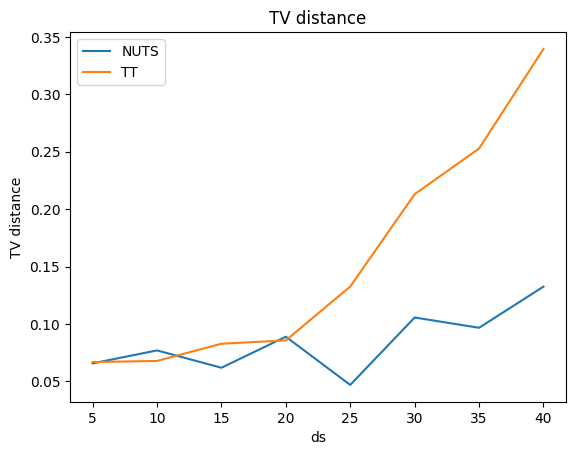

In [53]:
plt.plot(ds, nuts_tv, label='NUTS')
plt.plot(ds, tt_tv, label='TT')
plt.legend()
plt.title("TV distance")
plt.xlabel("ds")
plt.ylabel("TV distance")
plt.show()